# Klasyfikacja raka mózgu - Hubert Jaremko

## Proces przetwarzania danych

### Opis zestawu danych
Cheng, Jun (2017): brain tumor dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.1512427.v5 

Zestaw danych zawiera 3064 obrazów z przewagą T1 pochodzących od 233 pacientów z trzema rodzajami nowotworów mózgu:
 - oponiak (*meningioma*, 708 obrazów), 
 - glejak (*glioma*, 1426 obrazów),
 - nowotwór przysadki (*pituitary tumor*, 930 obrazów).

Dane zostały zorganizowe w formacie matlaba (pliki `.mat`).
Każdy plik przechowuje strukture danych składającą się z następujących pól:
 - `cjdata.label`: `1` oznaczający oponiaka, `2` gelajka, `3` guz przysadki
 - `cjdata.PID`: ID pacjenta
 - `cjdata.image`: dane obrazu
 - `cjdata.tumorBorder`: wektor zawierajacy koordynaty punktów na granicy guza.
 - `cjdata.tumorMask`: obraz binarny, w którym jedynki oznaczają region guza

### Wczytanie obrazów

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
cancer_type = {1 : 'Oponiak', 2 : 'Glejak', 3 : 'Guz przysadki'}

In [3]:
def from_raw_pid(raw_pid):
    return ''.join([chr(c[0]) for c in raw_pid])

def from_raw_label(raw_label):
    return int(raw_label[0][0])

def from_raw(raw):
    return raw[0][0]

def from_raw_image(raw_image):
    return np.asarray(raw_image)

def read_raw_brain_data(index):
    import h5py
    brain_path = f'data/raw/{index}.mat'
    
    with h5py.File(brain_path, 'r') as file:
        # pid = from_raw_pid(list(file['cjdata']['PID']))
        image = from_raw_image(list(file['cjdata']['image']))
        label = from_raw_label(list(file['cjdata']['label']))
        return (image, label)
    return None

In [4]:
# data_amount = 3064
data_amount = 50
brains_data = [read_raw_brain_data(i) for i in range(1, data_amount)]

In [11]:
def plot_images(columns, rows, data):
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns * rows + 1):
        img = data[i][0]
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(cancer_type[data[i][1]], fontsize=20)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.imshow(img, cmap='gray')
    plt.show()

In [7]:
def filter_by_type(t):
    return list(filter(lambda x: x[1] == t, brains_data))

type_1 = filter_by_type(1)
type_2 = filter_by_type(2)
type_3 = filter_by_type(3)
print(f"Type 1 images: {len(type_1)}")
print(f"Type 2 images: {len(type_2)}")
print(f"Type 3 images: {len(type_3)}")

Type 1 images: 49
Type 2 images: 0
Type 3 images: 0


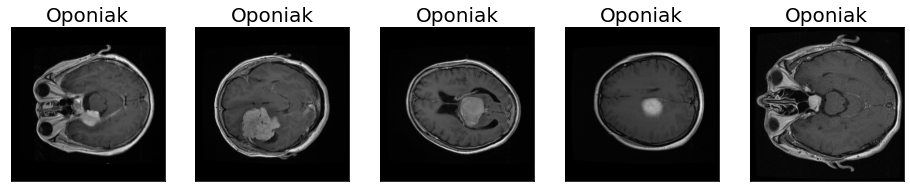

In [12]:
import random

random.shuffle(type_1)
random.shuffle(type_2)
random.shuffle(type_3)

plot_images(5, 1, type_1)
# plot_images(5, 1, type_2)
# plot_images(5, 1, type_3)

In [13]:
def plot_data_dist(type_1, type_2, type_3):
    df = pd.DataFrame(data={'Zestawy danych': [len(type_1), len(type_2), len(type_3)]}, index=[cancer_type[1], cancer_type[2], cancer_type[3]])
    df.plot(kind='bar', rot=0, legend=None)
    plt.title("Ilość zestawów danych ze wględu na rodzaj guza")
    plt.show()

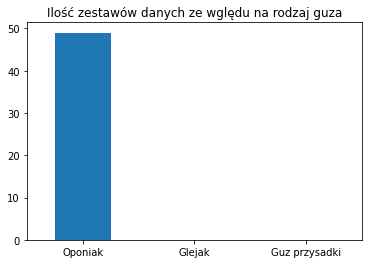

In [14]:
plot_data_dist(type_1, type_2, type_3)

### Preprocessing
Ze względu na duży rozmiar obrazów oraz nierówny rozkład klas nowotworu (zob. wykres) zostaną wykonanne następujące kroki:
- Kompresja oraz przycięcie obrazów do rozmiary 256 $\times$ 256.
- Uzupełnienie brakujących klas nowotwórów przez wzorst danych.

In [19]:
brains_data[0][0].shape

(512, 512)

In [28]:
brains = pd.DataFrame(data=brains_data, columns=['image', 'tumor_class'])
print(brains.head())
print(brains.info())
print(brains.describe())

                                               image  tumor_class
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        49 non-null     object
 1   tumor_class  49 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 912.0+ bytes
None
       tumor_class
count         49.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0


In [44]:
shapes = {}

for img in brains['image']:
    shapes[img.shape] = 0
    
for img in brains['image']:
    shapes[img.shape] += 1

shapes

{(512, 512): 49}

## Proces modelowania

## Porównanie modeli

## Wizualizacja wyników

## Podsumowanie pracy